# Imports

In [1]:
import os
import json
from pprint import pprint

import pandas as pd
from groq import Groq
from jigsawstack import JigsawStack
from sqlalchemy import create_engine
from e2b_code_interpreter import Sandbox
from dotenv import load_dotenv, find_dotenv

In [2]:
load_dotenv(find_dotenv())
assert not os.getenv("JIGSAWSTACK_API") is None
assert not os.getenv("GROQ_API_KEY") is None
assert not os.getenv("E2B_API_KEY") is None

In [3]:
def jigsaw_query(prompt, sql_schema, verbose=False):
    if verbose:
        print(sql_schema)
    params = {
        "prompt": prompt,
        "sql_schema": sql_schema,
        'database': 'sqlite',
    }
    result = jigsawstack.text_to_sql(params)
    
    sql_query = result['sql']
    return sql_query

# Setup

## APIs

In [4]:
jigsawstack = JigsawStack(
    api_key = os.getenv("JIGSAWSTACK_API")
)

In [5]:
client = Groq(
    api_key = os.getenv("GROQ_API_KEY")
)

In [6]:
# Create sandbox instance (by default, sandbox instances stay alive for 5 mins)
sbx = Sandbox(
    api_key = os.getenv('E2B_API_KEY'),
    request_timeout=3_600,
)

## data

In [7]:
product_table_df = pd.read_csv('data/tables/Product Table.csv')
invoice_table_df = pd.read_csv('data/tables/Invoice Table.csv')
invoice_item_df = pd.read_csv('data/tables/Invoice Item.csv')
outlet_df = pd.read_csv('data/tables/Outlet Table.csv')
warehouse_df = pd.read_csv('data/tables/Warehouse Table.csv')
address_df = pd.read_csv('data/tables/Address Table.csv')

## SQLlite

In [8]:
!rm -v my_database.db

removed 'my_database.db'


In [9]:
engine = create_engine('sqlite:///my_database.db')

In [10]:
product_table_df.to_sql('datachat_product', engine, index=False, if_exists='replace')
invoice_table_df.to_sql('datachat_invoice', engine, index=False, if_exists='replace')
invoice_item_df.to_sql('datachat_invoiceitem', engine, index=False, if_exists='replace')
outlet_df.to_sql('datachat_outlet', engine, index=False, if_exists='replace')
warehouse_df.to_sql('datachat_warehouse', engine, index=False, if_exists='replace')
address_df.to_sql('datachat_address', engine, index=False, if_exists='replace')

5

In [11]:
product_table_schema_sql = pd.io.sql.get_schema(product_table_df, 'datachat_product', con=engine)
invoice_table_schema_sql = pd.io.sql.get_schema(invoice_table_df, 'datachat_invoice', con=engine)
invoice_item_schema_sql = pd.io.sql.get_schema(invoice_item_df, 'datachat_invoiceitem', con=engine)
outlet_schema_sql = pd.io.sql.get_schema(outlet_df, 'datachat_outlet', con=engine)
warehouse_schema_sql = pd.io.sql.get_schema(warehouse_df, 'datachat_warehouse', con=engine)
address_schema_sql = pd.io.sql.get_schema(address_df, 'datachat_address', con=engine)

In [12]:
# concatenate them

In [13]:
# Create a dictionary to map table names to their schemas
schemas = {
    'datachat_product': product_table_schema_sql,
    'datachat_invoice': invoice_table_schema_sql,
    'datachat_invoiceitem': invoice_item_schema_sql,
    'datachat_outlet': outlet_schema_sql,
    'datachat_warehouse': warehouse_schema_sql,
    'datachat_address': address_schema_sql,
}

# Now, build a valid SQL script:
sql_script = "-- DataChat Database Schema\n\nBEGIN;\n\n"

for table, schema in schemas.items():
    # Optionally remove any extraneous whitespace and ensure no duplicate semicolons:
    cleaned_schema = schema.strip().rstrip(";")
    sql_script += f"-- Table: {table}\n{cleaned_schema};\n\n"

sql_script += "COMMIT;\n"

# You can then print, write to a file, or execute this script:
print(sql_script)

-- DataChat Database Schema

BEGIN;

-- Table: datachat_product
CREATE TABLE datachat_product (
	id BIGINT, 
	product_code TEXT, 
	name TEXT
);

-- Table: datachat_invoice
CREATE TABLE datachat_invoice (
	invoice_id BIGINT, 
	timestamp TEXT, 
	subtotal FLOAT, 
	gst FLOAT, 
	total BIGINT, 
	origin_address_id BIGINT, 
	origin_address_type BIGINT
);

-- Table: datachat_invoiceitem
CREATE TABLE datachat_invoiceitem (
	id BIGINT, 
	invoice_id BIGINT, 
	product_id BIGINT, 
	"quantity " BIGINT, 
	price BIGINT, 
	line_total BIGINT
);

-- Table: datachat_outlet
CREATE TABLE datachat_outlet (
	id BIGINT, 
	name TEXT, 
	address_id BIGINT
);

-- Table: datachat_warehouse
CREATE TABLE datachat_warehouse (
	id BIGINT, 
	name TEXT, 
	address_id BIGINT
);

-- Table: datachat_address
CREATE TABLE datachat_address (
	id BIGINT, 
	street TEXT, 
	"postal code" BIGINT
);

COMMIT;



In [14]:
# To-Do add foreign keys to link them

# function - determine whether to get visualisation

In [15]:
messages_visualisation = [
    {"role": "system", "content": "Validate whether the user requires visualisation in the task. If only table output is required, reply false. If matplotlib is required to show some plots, reply true."},
    {"role": "user", "content": "I want to find out how D0001 and T0001 perform across outlets 1 to 2. Please output the results in a table where column headers are outlet names and row headers are product names"},
    {"role": "assistant", "content": json.dumps({ "require matplotlib" : False })},
    {"role": "user", "content": "Please track all invoices by location and create a bar chart in excel where x axis is outlet or warehouse name and y axis is sales amount"},
    {"role": "assistant", "content": json.dumps({ "require matplotlib" : True })},
    {"role": "user", "content": "I want to find out what percentage of my total sales come from outlet sales"},
    {"role": "assistant", "content": json.dumps({ "require matplotlib" : False })},
    {"role": "user", "content": None},
]

In [16]:
def perform_visualisation(result_df, user_query):
    python_template = """
    ```python
    def function_v1(insert arguments here):
        # Insert code here
    ```
    """
    SYSTEM_PROMPT = f"""
    You are a Python data scientist. 
    Use this template:
    
    {python_template}
    
    Do not use xlsxwriter
    Use matplotlib
    """.strip()
    
    ### groq(qwen-2.5-coder-32b)
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": (
            f"{result_df}\n"
            "Given the above results\n"
            f"{user_query}"
        )},
    ]
    print(messages[-1]['content'])
    
    # Get code from Groq
    response = client.chat.completions.create(
        model = "qwen-2.5-coder-32b",
        messages = messages
    )
    # Extract and run the code
    code = response.choices[0].message.content
    if "```python" in code:
        code = code.split("```python")[1].split("```")[0]
    print(code)
    
    ### e2b - Eecute visualisation code
    sbx = Sandbox(
        api_key = os.getenv('E2B_API_KEY'),
        request_timeout=3_600,
    )
    
    print("\nExecuting code in sandbox...")
    execution = sbx.run_code(code)
    pprint(execution)
    
    if len(execution.logs.stdout):
        print(execution.logs.stdout[0])
        
    if len(execution.results):
        execution.results[0]
    
    return execution.results[0]

# Inference - Data Analytics

## Few Shot Prep

In [18]:
user_query_v1 = "I want to find out how D0001 and T0001 perform across outlets 1 to 2. Please output the results in a table where column headers are outlet names and row headers are product names"
print(user_query_v1)

I want to find out how D0001 and T0001 perform across outlets 1 to 2. Please output the results in a table where column headers are outlet names and row headers are product names


In [19]:
expected_response_v1 = """
SELECT 
    p.product_code,
    SUM(CASE WHEN o.name = "Outlet 1" THEN ii.line_total ELSE 0 END) AS "Outlet 1" ,
    SUM(CASE WHEN o.name = "Outlet 2" THEN ii.line_total ELSE 0 END) AS "Outlet 2"
FROM datachat_outlet o
    JOIN datachat_invoice i ON i.origin_address_id = o.address_id
        JOIN datachat_invoiceitem ii ON ii.invoice_id = i.invoice_id
            JOIN datachat_product p ON p.id = ii.product_id
WHERE p.product_code IN ('D0001', 'T0001')
GROUP BY p.product_code;
"""
print(expected_response_v1)


SELECT 
    p.product_code,
    SUM(CASE WHEN o.name = "Outlet 1" THEN ii.line_total ELSE 0 END) AS "Outlet 1" ,
    SUM(CASE WHEN o.name = "Outlet 2" THEN ii.line_total ELSE 0 END) AS "Outlet 2"
FROM datachat_outlet o
    JOIN datachat_invoice i ON i.origin_address_id = o.address_id
        JOIN datachat_invoiceitem ii ON ii.invoice_id = i.invoice_id
            JOIN datachat_product p ON p.id = ii.product_id
WHERE p.product_code IN ('D0001', 'T0001')
GROUP BY p.product_code;



In [20]:
user_query_v2 = "I want to find out what percentage of my total sales come from outlet sales"
print(user_query_v2)

I want to find out what percentage of my total sales come from outlet sales


In [21]:
expected_response_v2 = """
SELECT 
  (SUM(i.total) * 100.0 / (SELECT SUM(total) FROM datachat_invoice)) AS outlet_sales_percentage
FROM datachat_invoice i
JOIN datachat_outlet w 
    ON i.origin_address_id = w.address_id
WHERE i.origin_address_type = 1;
"""
print(expected_response_v2)


SELECT 
  (SUM(i.total) * 100.0 / (SELECT SUM(total) FROM datachat_invoice)) AS outlet_sales_percentage
FROM datachat_invoice i
JOIN datachat_outlet w 
    ON i.origin_address_id = w.address_id
WHERE i.origin_address_type = 1;



In [22]:
fewshot_examples_lst = [
    user_query_v1, expected_response_v1,
    user_query_v2, expected_response_v2,
]
pprint(fewshot_examples_lst)

['I want to find out how D0001 and T0001 perform across outlets 1 to 2. Please '
 'output the results in a table where column headers are outlet names and row '
 'headers are product names',
 '\n'
 'SELECT \n'
 '    p.product_code,\n'
 '    SUM(CASE WHEN o.name = "Outlet 1" THEN ii.line_total ELSE 0 END) AS '
 '"Outlet 1" ,\n'
 '    SUM(CASE WHEN o.name = "Outlet 2" THEN ii.line_total ELSE 0 END) AS '
 '"Outlet 2"\n'
 'FROM datachat_outlet o\n'
 '    JOIN datachat_invoice i ON i.origin_address_id = o.address_id\n'
 '        JOIN datachat_invoiceitem ii ON ii.invoice_id = i.invoice_id\n'
 '            JOIN datachat_product p ON p.id = ii.product_id\n'
 "WHERE p.product_code IN ('D0001', 'T0001')\n"
 'GROUP BY p.product_code;\n',
 'I want to find out what percentage of my total sales come from outlet sales',
 '\n'
 'SELECT \n'
 '  (SUM(i.total) * 100.0 / (SELECT SUM(total) FROM datachat_invoice)) AS '
 'outlet_sales_percentage\n'
 'FROM datachat_invoice i\n'
 'JOIN datachat_outlet w \n'


## Prompt 1

In [25]:
user_query = "I want to find out how D0001 and R0001 perform across outlets 1 to 3. Please output the results in a table where column headers are outlet names and row headers are product names"
print(user_query)

I want to find out how D0001 and R0001 perform across outlets 1 to 3. Please output the results in a table where column headers are outlet names and row headers are product names


In [26]:
user_query_fewshot = '\n'.join(fewshot_examples_lst + [user_query])
sql_query = jigsaw_query(user_query_fewshot, sql_script)
result_df = pd.read_sql_query(sql_query, engine)
result_df

,product_code,Outlet 1,Outlet 2,Outlet 3
0,D0001,200,400,1200
1,R0001,200,1000,600


In [27]:
messages_visualisation[-1]['content'] = user_query

response = client.chat.completions.create(
    model = "qwen-2.5-coder-32b",
    messages = messages_visualisation
)

require_visualisation_dict = json.loads(response.choices[0].message.content)
pprint(require_visualisation_dict)
if require_visualisation_dict['require matplotlib']:
    plot_fig = perform_visualisation(result_df, user_query)

{'require matplotlib': False}


## Prompt 2

In [29]:
user_query = "I want to find out what percentage of my total sales come from warehouse sales"

In [30]:
user_query_fewshot = '\n'.join(fewshot_examples_lst + [user_query])

sql_query = jigsaw_query(user_query_fewshot, sql_script)

result_df = pd.read_sql_query(sql_query, engine)
result_df

,warehouse_sales_percentage
0,40.47619


In [31]:
messages_visualisation[-1]['content'] = user_query

response = client.chat.completions.create(
    model = "qwen-2.5-coder-32b",
    messages = messages_visualisation
)

require_visualisation_dict = json.loads(response.choices[0].message.content)
pprint(require_visualisation_dict)
if require_visualisation_dict['require matplotlib']:
    plot_fig = perform_visualisation(result_df, user_query)

{'require matplotlib': False}


## Prompt 3

In [33]:
user_query = "Please track all invoices by location and create a bar chart where x axis is outlet or warehouse name and y axis is sales amount"

In [34]:
user_query_fewshot = '\n'.join(fewshot_examples_lst + [user_query])

sql_query = jigsaw_query(user_query_fewshot, sql_script)

result_df = pd.read_sql_query(sql_query, engine)
result_df

,location_name,sales_amount
0,Outlet 1,400
1,Outlet 2,1550
2,Outlet 3,1800
3,Warehouse 1,650
4,Warehouse 2,1900


In [35]:
messages_visualisation[-1]['content'] = user_query

response = client.chat.completions.create(
    model = "qwen-2.5-coder-32b",
    messages = messages_visualisation
)

require_visualisation_dict = json.loads(response.choices[0].message.content)
pprint(require_visualisation_dict)
if require_visualisation_dict['require matplotlib']:
    plot_fig = perform_visualisation(result_df, user_query)

{'require matplotlib': True}
  location_name  sales_amount
0      Outlet 1           400
1      Outlet 2          1550
2      Outlet 3          1800
3   Warehouse 1           650
4   Warehouse 2          1900
Given the above results
Please track all invoices by location and create a bar chart where x axis is outlet or warehouse name and y axis is sales amount

import matplotlib.pyplot as plt
import pandas as pd

def plot_sales_by_location(df):
    # Extracting the location and sales amount from the DataFrame
    locations = df['location_name']
    sales_amounts = df['sales_amount']
    
    # Creating the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(locations, sales_amounts, color='skyblue')
    
    # Adding title and labels
    plt.title('Sales Amount by Location')
    plt.xlabel('Location')
    plt.ylabel('Sales Amount')
    
    # Rotating the x-axis labels for better visibility
    plt.xticks(rotation=45, ha='right')
    
    # Display the plot
    plt.tight_layout()
    

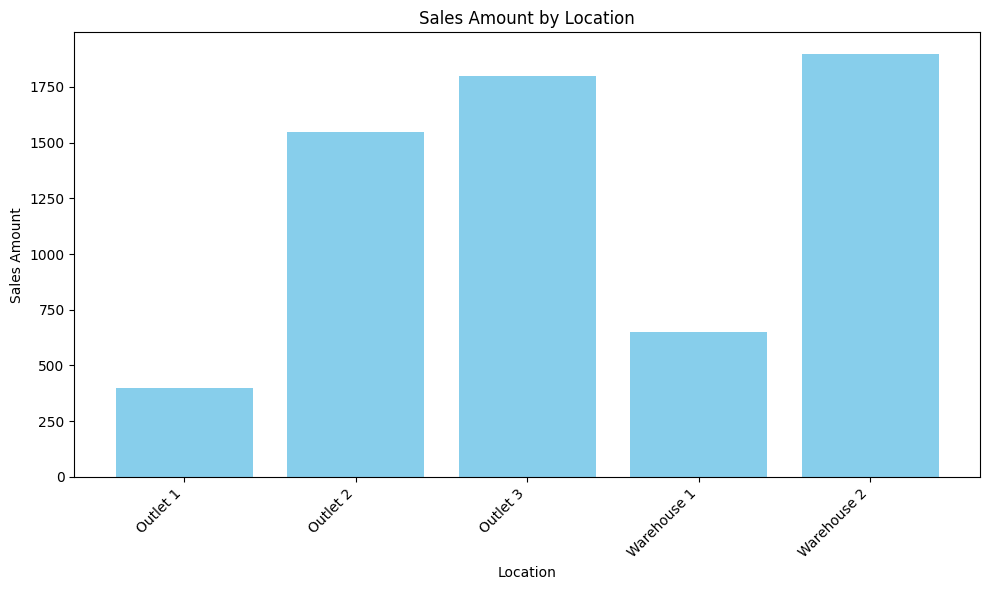

In [36]:
plot_fig

# Test

In [33]:
user_query = ""

In [ ]:
user_query_fewshot = '\n'.join(fewshot_examples_lst + [user_query])

sql_query = jigsaw_query(user_query_fewshot, sql_script)

result_df = pd.read_sql_query(sql_query, engine)
result_df

In [ ]:
messages_visualisation[-1]['content'] = user_query

response = client.chat.completions.create(
    model = "qwen-2.5-coder-32b",
    messages = messages_visualisation
)

require_visualisation_dict = json.loads(response.choices[0].message.content)
pprint(require_visualisation_dict)
if require_visualisation_dict['require matplotlib']:
    plot_fig = perform_visualisation(result_df, user_query)

In [ ]:
plot_fig